<a href="https://colab.research.google.com/github/Zumbergz/Team2Project/blob/main/GMITTeam2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tweepy

In [ ]:
# get data fron the csv files in the github repo
# return as csv using panda

github_data_url = "https://raw.githubusercontent.com/Zumbergz/Team2Project/main/data/"
file_ext = ".csv"

consumer_key = "dJuMEvznakyAek8dmFRbBw230"
consumer_secret = "Ke1Gs5uFrH5N5D2oycBnu83L7AN6T0q86lFmjS8AU4N7j6KSUB"
access_token = "1334228186327113734-X7LB7nsdacqUXhL4Y7gQBOMCo6OHsk"
access_token_secret = "SQeX7Gxs916QgZ4OvDAqiofuLd4xDvM5uY5tG6EjDdqp7"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

def get_data(file_name, flip):
  data = pd.read_csv(github_data_url + file_name + file_ext)
  if flip:
    return data.iloc[::-1]
  return data

In [ ]:
# all loaded datasets

covid_data = get_data("covid_cases", False)
asia_data = get_data("asia_dow", True)
ftse_data = get_data("ftse", True)
nasdaq_data = get_data("nasdaq", True)
sp_data = get_data("sp500", True)

In [ ]:
# maps of all the stock indices

index_countries = {
    "asia": ["Japan", "Australia", "China", "Hong Kong", "Korea (South)", "Taiwan", "India", "Indonesia", "Malaysia", "Singapore"],
    "ftse": ["United Kingdom"],
    "nasdaq": [],
    "sp": ["United States of America"]
}

index_dataset = {
    "asia": asia_data,
    "ftse": ftse_data,
    "nasdaq": nasdaq_data,
    "sp": sp_data
}

In [ ]:
!pip install tweepy

In [ ]:
# gets the cases for a list of countries
def cases_per_countries(countries):
  # return full list if no countries specified
  if countries == []:
    return covid_data

  # adds covid data to new list for specific countries
  country_data = []
  for country in countries:
    country_data.append(covid_data.loc[covid_data["Country"] == country])
  return country_data

[       CountryIndex         Country        Date    Cases
26000            66  United Kingdom  22/01/2020        0
26001            66  United Kingdom  23/01/2020        0
26002            66  United Kingdom  24/01/2020        0
26003            66  United Kingdom  25/01/2020        0
26004            66  United Kingdom  26/01/2020        0
...             ...             ...         ...      ...
26515            66  United Kingdom  20/06/2021  4646068
26516            66  United Kingdom  21/06/2021  4656536
26517            66  United Kingdom  22/06/2021  4668043
26518            66  United Kingdom  23/06/2021  4683986
26519            66  United Kingdom  24/06/2021  4700691

[520 rows x 4 columns]]


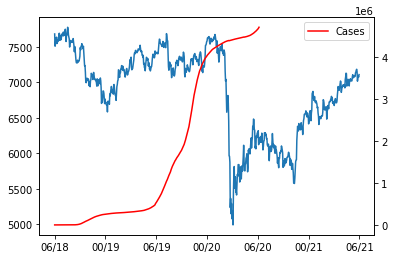

In [ ]:
def create_plot(data, countries):
  my_xticks = ['06/18','00/19','06/19','00/20', '06/20', '00/21', '06/21']
  length = len(data["Date"])
  x_pos = np.arange(0,length+1,length/(len(my_xticks)-1))
  plt.plot(data["Date"],data["Open"], label='Ftse')
  plt.twinx()
  plt.xticks(x_pos, my_xticks)
  plt.plot(countries[0]["Date"], countries[0]["Cases"], 'r', label = 'Cases')
  plt.legend()
  plt.show()

print(cases_per_countries(["United Kingdom"])) 
create_plot(ftse_data, cases_per_countries(["United Kingdom"]))


In [ ]:
def combine_country_cases(countries):
  summing = countries[0]
  for i in range(1, len(countries)+1,1 ):
    print(countries[i])
    summing["Cases"].add(countries[i-1]["Cases"], fill_value=0)
  return summing["Cases"]

print(cases_per_countries(["United Kingdom"]))
print(combine_country_cases(cases_per_countries(["United Kingdom", "United States of America"])))

[       CountryIndex         Country        Date    Cases
26000            66  United Kingdom  22/01/2020        0
26001            66  United Kingdom  23/01/2020        0
26002            66  United Kingdom  24/01/2020        0
26003            66  United Kingdom  25/01/2020        0
26004            66  United Kingdom  26/01/2020        0
...             ...             ...         ...      ...
26515            66  United Kingdom  20/06/2021  4646068
26516            66  United Kingdom  21/06/2021  4656536
26517            66  United Kingdom  22/06/2021  4668043
26518            66  United Kingdom  23/06/2021  4683986
26519            66  United Kingdom  24/06/2021  4700691

[520 rows x 4 columns]]
       CountryIndex                   Country        Date     Cases
96720           241  United States of America  22/01/2020         1
96721           241  United States of America  23/01/2020         1
96722           241  United States of America  24/01/2020         2
96723           24

IndexError: ignored

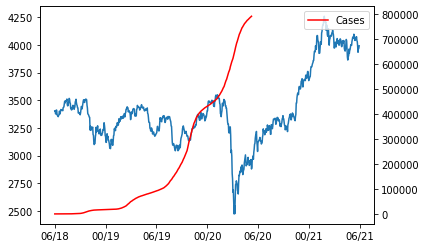

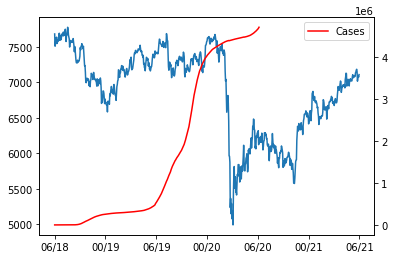

KeyError: ignored

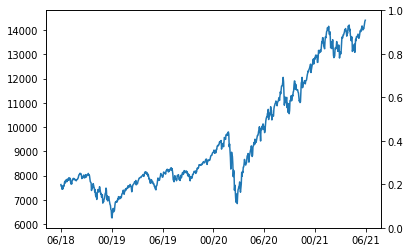

In [ ]:
# loops all index data and creates index/covid cases graphs

for key, value in index_countries.items():
  countries = cases_per_countries(value)
  create_plot(index_dataset[key], countries) # another param for countries for covid cases